# TicTacToe using SARSA - part 2.75 - Convolution NN

In part 2 I used a 9x36x36x9 NN architecture to create a decent TicTacToe AI agent. 

Here I will try to create a Convolutional NN.

No changes for modules

In [58]:
from BaseAgent import BaseAgent
from BaseEnvironment import BaseEnvironment
from RLGlue import RLGlue
from Softmax import softmax
from SimpleNN import ConvKerasNN

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The states now have to be changed to be 1x3x3x1

In [62]:
class TicTacToeEvnironment(BaseEnvironment):
    def env_init(self, env_info={}):
        pass
    
    def env_start(self):
        self.terminal = False
        self.board = np.zeros((3, 3))
        self.reward_obs_term = (0, self.board, False)
        return self.board[np.newaxis,:,:,np.newaxis], self.get_mask()
    
    def env_step(self, agent_num, index):
        if self.terminal:
            print("Environment in terminal state, please restart.")
        
        row, col = self.transform_index(index)
        self.board[row, col] = agent_num
        
        if self.check_won(agent_num):
            reward = 10
            self.terminal = True
        elif self.check_tie():
            reward = 0
            self.terminal = True
        else:
            reward = -1
            
        self.reward_obs_term_mask = (reward, self.board[np.newaxis,:,:,np.newaxis], self.terminal, self.get_mask())
        return self.reward_obs_term_mask
    
    def check_tie(self):
        return (self.board == 0).sum() == 0
    
    def check_won(self, agent_num):
        for row in self.board:
            if np.array_equal(row, agent_num * np.ones((3,))):
                return True
        for col in self.board.T:
            if np.array_equal(col, agent_num * np.ones((3,))):
                return True
        diag = np.diag(self.board)
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        diag = np.diag(np.fliplr(self.board))
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        return False
    
    def env_cleanup(self):
        pass
    
    def env_message(self, message):
        if message == 0:  # return available indices mask
            return self.get_mask()
            
    def get_mask(self):
        rows, cols = np.where(self.board == 0)
        indices = rows * 3 + cols
        mask = np.zeros((9,))
        mask[indices] = 1
        return mask
    
    def transform_index(self, index):
        return index // 3, index % 3

In [63]:
class TicTacToeAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        self.discount = agent_init_info["discount"]        
        self.network = agent_init_info["network"]
        self.tau = agent_init_info["tau"]
        self.num_actions = agent_init_info["num_actions"]
        
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        self.last_state = None
        self.last_action = None

    def policy(self, state, mask):
        action_values = self.network.predict(state)
        probs = softmax(action_values, self.tau) 
        probs *= mask
        probs /= probs.sum()
        action = self.rand_generator.choice(self.num_actions, p=probs.squeeze())
        return action

    def agent_start(self, state, mask):
        self.last_state = state
        self.last_action = self.policy(self.last_state, mask)
        return self.last_action        

    def agent_step(self, reward, state, mask):
        # SARSA
        action = self.policy(state, mask)
        target = self.network.predict(self.last_state)[0]
        correct = reward + self.discount * self.network.predict(state)[0][action]
        target[self.last_action] = correct
        self.network.train(self.last_state, target.reshape(1,-1))
        
        self.last_state = state
        self.last_action = action
        return action
    
    def agent_end(self, reward):
        # SARSA
        target = self.network.predict(self.last_state)[0]
        target[self.last_action] = reward
        self.network.train(self.last_state, target.reshape(1, -1))
        
    def agent_message(self, message):
        pass

Let's try now using a 8 filters of 3x3 conv-network. This has ~150 parameters. 

![nn](conv.png)

In [64]:
# define the function approximator - a Feed-Forward NN 
nn1 = ConvKerasNN(lr=0.01)
nn2 = ConvKerasNN(lr=0.01)

In [82]:
runs = 30000  # 

In [73]:
nn1.model.get_weights()[0][0][0]

array([[-1.203671  ,  0.9172778 ,  1.1685048 ,  0.44450146,  2.6788044 ,
         0.66939425,  3.9265857 ,  2.4774685 , -2.3097682 ]],
      dtype=float32)

In [77]:
nn1.model.get_weights()[0][0][0]

array([[-0.57780147,  0.3325437 ,  1.978238  ,  0.17420025,  2.4541123 ,
         0.84699863,  4.235396  ,  2.0596092 ,  0.1503725 ]],
      dtype=float32)

In [81]:
nn1.model.get_weights()[0][0][0]

array([[-0.46507373, -0.7070068 ,  1.4121308 , -0.8786079 ,  1.4875815 ,
         0.30703622,  5.592644  ,  1.4953539 ,  2.951543  ]],
      dtype=float32)

In [87]:
nn1.model.get_weights()[0][0][0]

array([[-1.2830435 ,  0.7925793 ,  3.1802733 , -2.1963038 ,  1.9061103 ,
        -0.31781238,  7.3209906 ,  1.1407467 ,  2.5032465 ]],
      dtype=float32)

In [66]:
def experiment(runs, nns):
    rlglue = RLGlue(TicTacToeEvnironment, TicTacToeAgent, TicTacToeAgent)
    rewards = np.zeros((runs, 2))
    starts = np.zeros((runs, 1))
    final_states = np.zeros((runs, 3, 3, 1))
    agent1_info = {"discount": 1, "network": nns[0], "tau": 1, "num_actions": 9, "seed": 747}
    agent2_info = {"discount": 1, "network": nns[1], "tau": 1, "num_actions": 9, "seed": 101}
    env_info = {}
    rlglue.rl_init(agent1_info, agent2_info, env_info)

    for i in tqdm(range(runs)):
        rlglue.rl_episode(10)
        rewards[i, :], starts[i, :], final_states[i, :] =  rlglue.rl_return()
    return rlglue, rewards, starts, final_states

In [83]:
rlg, rew, starts, states = experiment(runs, [nn1, nn2])

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [09:19<00:00, 53.63it/s]


# Test

In [84]:
starts[-1], states[-1]

(array([-1.]), array([[[ 1.],
         [-1.],
         [-1.]],
 
        [[ 1.],
         [ 1.],
         [-1.]],
 
        [[ 1.],
         [-1.],
         [ 0.]]]))

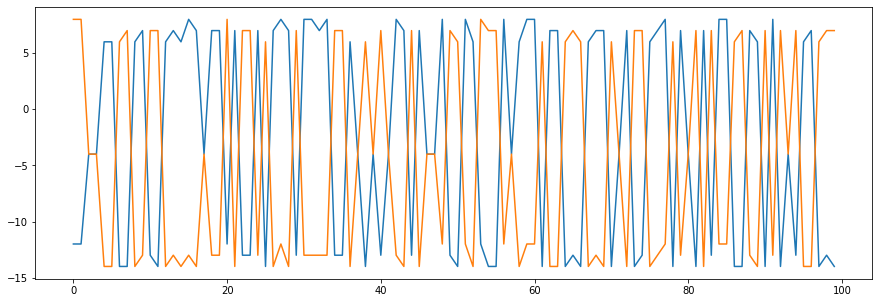

In [85]:
plt.figure(figsize=(15,5))
plt.plot(rew[-100:,])
plt.show()

In [70]:
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(4283, 4654)

In [76]:
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(4253, 4588)

In [80]:
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(4222, 4674)

In [86]:
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(13359, 13563)

In [88]:
(13359 + 13563) / 30000

0.8974

In [89]:
(4253 + 4588) / 10000

0.8841

Let's play a game:

In [23]:
ai = rlg.agents[-1]["agent"]

In [24]:
env = TicTacToeEvnironment()
env.env_init()
ret = env.env_start()

In [25]:
action = ai.agent_start(ret[0], ret[1])
action # ai chooses...

4

In [26]:
ret = env.env_step(-1, action)

In [27]:
# Human (aka - me) will play 0, top-left
ret = env.env_step(1, 0)

In [28]:
action = ai.agent_step(-1, ret[1], ret[3])
action # ai chooses...

1

In [29]:
ret = env.env_step(-1, action)

In [30]:
# Human (aka - me) will play 7, to block agent
ret = env.env_step(1, 7)

In [31]:
action = ai.agent_step(-1, ret[1], ret[3])
action # ai chooses...

6

In [32]:
ret = env.env_step(-1, action)

In [33]:
# let's pretend I missed the blocking at 2 to avoid a tie
ret = env.env_step(1, 5)

In [34]:
action = ai.agent_step(-1, ret[1], ret[3])
action # ai chooses...

2

In [35]:
env.env_step(-1, action)  # ai wins

(10,
 array([[ 1., -1., -1.,  0., -1.,  1., -1.,  1.,  0.]]),
 True,
 array([0., 0., 0., 1., 0., 0., 0., 0., 1.]))

Let's play another round:

In [51]:
ret = env.env_start()

In [52]:
action = ai.agent_start(ret[0], ret[1])
action # ai chooses...

4

In [53]:
ret = env.env_step(-1, action)

In [54]:
# I choose 6
ret = env.env_step(1, 6)

In [55]:
action = ai.agent_step(-1, ret[1], ret[3])
action

7

In [56]:
ret = env.env_step(-1, action)
# I choose 1
ret = env.env_step(1, 1)

In [57]:
action = ai.agent_step(-1, ret[1], ret[3])
action

0

In [58]:
ret = env.env_step(-1, action)
# I choose 8
ret = env.env_step(1, 8)

In [59]:
action = ai.agent_step(-1, ret[1], ret[3])
action

2

In [61]:
ret = env.env_step(-1, action)
# I choose 3
ret = env.env_step(1, 3)

In [62]:
action = ai.agent_step(-1, ret[1], ret[3])
action

5

In [63]:
env.env_step(-1, action) # game ends with a tie

(0,
 array([[-1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.]]),
 True,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Let's play another game, where I start.

In [64]:
ret = env.env_start()

In [65]:
# I choose the 4
ret = env.env_step(1, 4)

In [66]:
action = ai.agent_start(ret[1], ret[3])
action # ai chooses...

6

In [67]:
ret = env.env_step(-1, action)
# I choose 0
ret = env.env_step(1, 0)

In [69]:
ret

(-1,
 array([[ 1.,  0.,  0.,  0.,  1.,  0., -1.,  0.,  0.]]),
 False,
 array([0., 1., 1., 1., 0., 1., 0., 1., 1.]))

In [68]:
action = ai.agent_start(ret[1], ret[3])
action # ai chooses...

3

In [69]:
# let's save this agent
ai.network.model.save_weights("agent-4-keras-9-12-12-9.h5")